In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

# full globe jet finding

In [2]:
ds = xr.open_mfdataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/flat_wind/dailymean/2022*.nc")
dh = DataHandler(ds, "/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/flat_wind/dailymean/results")
exp = JetFindingExperiment(dh)

In [5]:
all_jets = exp.find_jets()

[########################################] | 100.00% Completed | 708.87 ms


  0%|          | 0/146 [00:00<?, ?it/s]


ValueError: cannot concat empty list

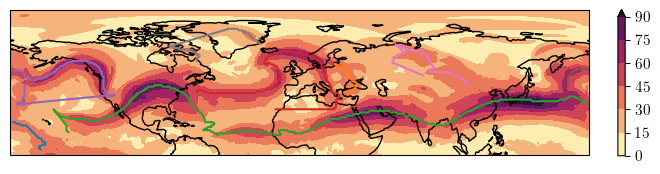

In [4]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds["s"][0]], cmap=colormaps.matter, levels=7)
jets = all_jets.filter(pl.col("time") == all_jets[0, "time"]) 
for indexer, jet in jets.group_by("jet ID"):
    lon, lat = jet[["lon", "lat"]].to_numpy().T
    plt.plot(lon, lat)

# arco-era5 tests

In [ ]:
ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"),
)
ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)

base_ds = (
    ar_full_37_1h[["u_component_of_wind", "v_component_of_wind"]]
    .sel(
        time=ar_full_37_1h.time.dt.hour % 6 == 0,
        latitude=ar_full_37_1h.latitude >= 0,
        level=[175, 200, 225, 250, 300, 350],
    )
    .isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))
)

base_path = Path(f"{DATADIR}/ERA5/plev/flat_wind/dailymean")
for year in YEARS:
    for month in range(1, 13):
        month_str = str(month).zfill(2)
        opath = base_path.joinpath(f"{year}{month_str}.nc")
        if opath.is_file():
            continue
        ds = compute(
            base_ds.sel(
                time=(base_ds.time.dt.year == year) & (base_ds.time.dt.month == month)
            ),
            progress=True,
        )
        ds = standardize(ds)
        ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
        ds = flatten_by(ds, "s")
        ds.to_netcdf(opath)
        print(f"Completed {year}{month}")

# Climatologies, datahandlers of new data

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "t2m", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "sst", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "mslp", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "apvs", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "cpvs", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "thetalev", "apvs", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=True)
    da.to_netcdf(data_path("ERA5", "thetalev", "apvs", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "plev", "z", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=True)
    da.to_netcdf(data_path("ERA5", "plev", "z", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
compute_all_smoothed_anomalies("ERA5", "plev", "z", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "thetalev", "cpvs", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=False)
    da.to_netcdf(data_path("ERA5", "thetalev", "cpvs", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
da_ = compute(da.sel(lev=350), progress_flag=True)

In [ ]:
da_

In [ ]:
da_ = pl.from_pandas(da_.to_dataframe().reset_index()).cast({"lat": pl.Float32, "lon": pl.Float32, "lev": pl.UInt16})

In [ ]:
da_

In [ ]:
da_.group_by(pl.col("time").dt.ordinal_day(), pl.col("lat"), pl.col("lon")).agg(pl.col("apvs").mean())

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "apvs", "6H", 'hourofyear', {'hourofyear': ('win', 60)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "cpvs", "6H", 'hourofyear', {'hourofyear': ('win', 60)}, None)

# new pvs das

In [ ]:
import polars_st as st

In [ ]:
def to_xarray(events: st.GeoDataFrame, dummy_da: xr.DataArray, varname: str):
    dummy_da = dummy_da.rename("dummy")
    da_df = pl.from_pandas(dummy_da.to_dataframe().reset_index())
    orig_times = da_df["time"]
    timedtype = orig_times.dtype
    da_df = da_df.drop("time", "dummy")
    da_df = da_df.unique(["lat", "lon"]).sort(["lat", "lon"]).with_columns(geometry=st.from_xy("lon", "lat"))
    da_df = st.GeoDataFrame(da_df)
    events = events.with_columns(pl.col("geometry").st.buffer(0.25))
    events = (
        events.select(["date", "geometry", varname])
        .cast({varname: pl.Float32})
        .rename({"date": "time"})
    )
    events = events.cast({"time": timedtype})
    events = events.filter(pl.col("time").is_in(orig_times))
    dummy_da = xr.zeros_like(dummy_da, dtype=np.float32)
    events = events.st.sjoin(da_df, on="geometry", how="inner", predicate="contains")
    events = events.unique(["time", "lon", "lat"])
    events_da = xr.DataArray.from_series(
        events[["time", varname, "lat", "lon"]]
        .to_pandas()
        .set_index(["time", "lat", "lon"])[varname]
    ).fillna(0)
    dummy_da.loc[
        {
            "time": events_da.time.values,
            "lat": events_da.lat.values,
            "lon": events_da.lon.values,
        }
    ] = events_da
    return dummy_da

In [ ]:
all_events = {}
for level in trange(310, 365, 5):
    events = st.from_geopandas(gpd.read_parquet(f"/storage/workspaces/giub_meteo_impacts/ci01/ERA5/RWB_index/era5_pv_streamers_{level}K_1959-2022.parquet"))

    tropospheric = events.filter(pl.col("mean_var") < pl.col("level"))
    anticyclonic = tropospheric.filter(pl.col("intensity") >= pl.col("level"))
    cyclonic = tropospheric.filter(pl.col("intensity") < pl.col("level"))
    
    all_events[level] = {"anti": anticyclonic, "cycl": cyclonic}

In [ ]:
for year in YEARS:
    # for month in range(1, 13):
    ofile_anti = Path(f"{DATADIR}/ERA5/thetalev/apvs/6H/{year}.nc")
    ofile_cycl = Path(f"{DATADIR}/ERA5/thetalev/cpvs/6H/{year}.nc")
    if ofile_cycl.is_file() and ofile_anti.is_file():
        continue
    time_mask = (TIMERANGE.year == year)# & (TIMERANGE.month == month)
    coords = {
        "time": TIMERANGE[time_mask],
        "lat": np.arange(0, 90.5, .5),
        "lon": np.arange(-180, 180, .5),
    }
    shape = [len(co) for co in coords.values()]
    dummy_da = xr.DataArray(np.zeros(shape), coords=coords)
    anti_all_levs = {}
    cycl_all_levs = {}
    for lev, events in tqdm(all_events.items(), total=11):
        anti_all_levs[lev] = to_xarray(events["anti"], dummy_da, "intensity")
        cycl_all_levs[lev] = to_xarray(events["cycl"], dummy_da, "intensity")
    anti_all_levs = xr.concat(anti_all_levs.values(), dim="lev").assign_coords(lev=list(anti_all_levs))
    cycl_all_levs = xr.concat(cycl_all_levs.values(), dim="lev").assign_coords(lev=list(cycl_all_levs))
    anti_all_levs.to_netcdf(ofile_anti)
    cycl_all_levs.to_netcdf(ofile_cycl)

# CESM

In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind")
paths = list(basepath.iterdir())
paths = [path for path in paths if path.suffix == ".nc" and path.name != "ds.nc"]
parts = [path.name.split(".")[0].split("-") for path in paths]
parts = np.asarray(parts)
sorted_order = np.argsort([memb.replace("r10", "r0") for memb in parts[:, 0]])
parts = parts[sorted_order]
paths = [paths[i] for i in sorted_order]
all_members = np.unique(parts[:, 0])
all_years = np.unique(parts[:, 1])

not_here = []
here = []
for year in all_years:
    for member in all_members:
        potential_path = basepath.joinpath(f"{member}-{year}.nc")
        if potential_path.is_file():
            here.append(potential_path)
        else:
            not_here.append(potential_path)
len(here)

from itertools import groupby
paths_to_load = []
valid_ensembles = []
for key, indices in groupby(range(len(parts)), lambda i: parts[i][0]):
    indices = list(indices)
    group = parts[indices]
    these_paths = [paths[i] for i in indices]
    years = np.asarray(list([g[1] for g in group]))
    if len(years) == 60:
        paths_to_load.append(these_paths)
        valid_ensembles.append(key)
    else:
        print(key, len(years))

In [ ]:
from tqdm import tqdm
ds = []
for ptl in tqdm(paths_to_load):
    ds_ = []
    for p in ptl:
        this = xr.open_dataset(p)
        this = this.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
        ds_.append(this)
    ds.append(xr.concat(ds_, dim="time"))
ds = xr.concat(ds, dim="member")
# ds = xr.concat([xr.concat([xr.open_dataset[ptl_] for ptl_ in ptl], dim="time") for ptl in paths_to_load], dim="member")

In [ ]:
import dask
from dask.distributed import progress, Client
from jetstream_hugo.definitions import COMPUTE_KWARGS
client = Client(**COMPUTE_KWARGS)
dask.persist(ds)
progress(ds, notebook=False)
ds = dask.compute(ds)

In [ ]:
ds = ds[0]
to_comp = ds.to_zarr(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", compute=False, encoding={var: {"chunks": (-1, 100, -1, -1)} for var in ds.data_vars}, mode="w")
dask.persist(to_comp)
progress(to_comp, notebook=False)
dask.compute(to_comp)

# extreme cesm clim

In [ ]:
import numpy as np
from jetstream_hugo.data import *
quantiles = ds["s"].quantile(np.arange(0.6, 1, 0.05), ["member", "lon", "lat"]).compute()
quantiles = smooth(quantiles, {"time": ("win", 15)}).load()
quantiles.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q.nc")


In [ ]:
from matplotlib.dates import DateFormatter, MonthLocator
from jetstream_hugo.definitions import *
from scipy.stats import linregress

def get_trend(da):
    years = np.unique(da.time.dt.year)
    if "jet" not in da.dims:
        result = linregress(years, da.values)
        return xr.Dataset({"slope": result.slope, "p": result.pvalue})
    jets = da.jet.values
    slopes = xr.DataArray(np.zeros(len(jets)), coords={"jet": jets})
    pvalues = slopes.copy()
    for j, jet in enumerate(jets):
        result = linregress(years, da.isel(jet=j).values)
        slopes[j] = result.slope
        pvalues[j] = result.pvalue
    return xr.Dataset({"slope": slopes, "p": pvalues})

winsize = 15
halfwinsize = int(np.ceil(winsize / 2))

fig, ax = plt.subplots()
for q, qval in zip(quantiles[::2], np.arange(0.6, 1, 0.05 * 2)):
    gb = q.groupby("time.dayofyear")
    x = list(gb.groups)
    x = DATERANGE[x]
    ys = gb.map(get_trend) 
    ps = ys["p"]
    ys = ys["slope"]
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=winsize, center=True).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)})
    ax.plot(x, ys, label=f"$q={qval:.1f}$", lw=2)
ax.grid(True)
ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
ax.xaxis.set_major_formatter(DateFormatter("1 %b"))
ax.set_xlim(min(x), max(x))
ax.legend()

In [ ]:
q_clim = compute_clim(quantiles, "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q_clim.nc")

In [ ]:
ds = ds.reset_coords("time_bnds", drop=True)

# Extreme experiment

In [ ]:
exp_tp = ExtremeExperiment(
    DataHandler("ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None),
    q = 0.95,
)
da_tp = exp_tp.da.load()

data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds = exp.props_as_ds(True)

In [ ]:
from deepdiff import DeepHash
DeepHash(load_pickle("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/6H/hourofyear_hourofyearwin60/results/1/predictions/1/metadata.pkl"))

In [ ]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "persistence", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = pd.Timedelta(0, "D")
n_clu = 22
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(n_clu, 0.95, minlen=np.timedelta64(1, "D"))
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

In [ ]:
clu = Clusterplot(1, 1, exp_tp.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

In [ ]:
compute_all_smoothed_anomalies("ERA5", "plev", "s", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

In [ ]:
basepath = Path(f"{DATADIR}/ERA5/surf")
varnames = ["u10", "v10", "s10"]
for year, month in tqdm(product(YEARS, range(1, 13)), total=len(YEARS) * 12):
    month_str = str(month).zfill(2)
    ofiles = {varname: basepath.joinpath(f"{varname}/6H/{year}{month_str}.nc") for varname in varnames}
    if all([ofile.is_file() for ofile in ofiles.values()]):
        continue
    ds = xr.open_dataset(basepath.joinpath(f"raw/{year}{month_str}.nc"))
    ds = ds.rename(longitude="lon", latitude="lat")
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby("lon")
    ds = ds.sortby("lat")
    ds["s10"] = np.sqrt(ds["u10"] ** 2 + ds["v10"] ** 2)
    for varname in varnames:
        da = ds[varname]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=xr.SerializationWarning)
            da.to_netcdf(ofiles[varname])